In [56]:
from PIL import Image
import pandas as pd
import numpy as np
import os
import io
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
import cv2
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import matplotlib.pyplot as plt
import io

In [57]:
def load_images(directory):
  images = []
  for filename in os.listdir(directory):
    img = Image.open(os.path.join(directory, filename))
    img = img.resize((244, 244))
    img = img.convert('RGB')
    img = np.array(img) / 255.0
    images.append(img)
  return images

In [58]:
data_positive_tumor = load_images('Brain-Tumour-Dataset/yes')
data_negative_tumor = load_images('Brain-Tumour-Dataset/no')

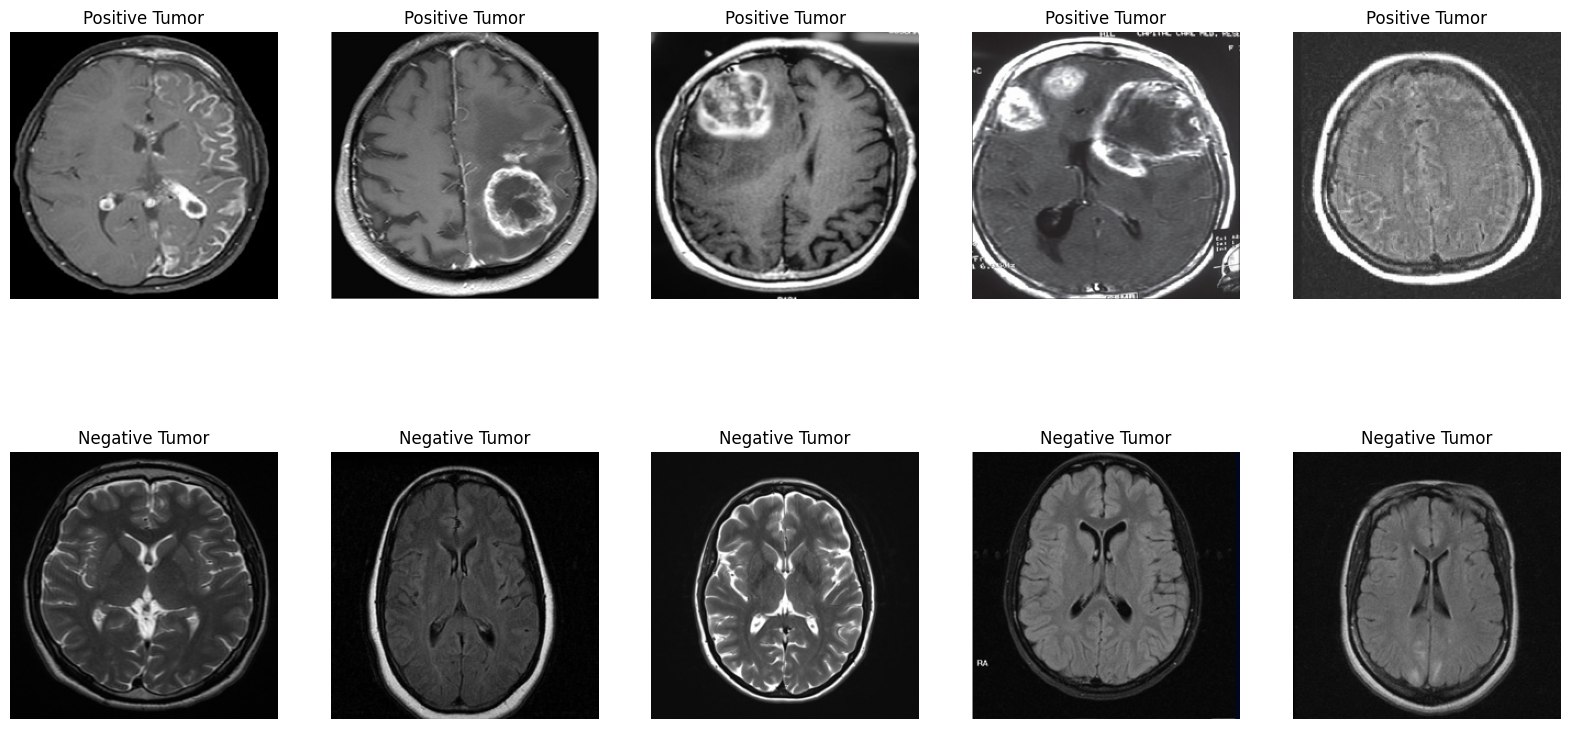

In [59]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for i in range(5):
    axes[0, i].imshow(data_positive_tumor[i])
    axes[0, i].set_title('Positive Tumor')
    axes[0, i].axis('off')

for i in range(5):
    axes[1, i].imshow(data_negative_tumor[i])
    axes[1, i].set_title('Negative Tumor')
    axes[1, i].axis('off')

plt.show()

In [60]:
def tumor_labelling(data_positive_tumor, data_negative_tumor):
  positive_labels = np.ones(len(data_positive_tumor))
  negative_labels = np.zeros(len(data_negative_tumor))
  return positive_labels, negative_labels
positive_labels, negative_labels = tumor_labelling(data_positive_tumor, data_negative_tumor)

In [61]:
solid_tumor = data_positive_tumor + data_negative_tumor
labels = np.concatenate((positive_labels, negative_labels), axis=0)

In [62]:
X = np.array(solid_tumor)
y = np.array(labels)

In [63]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(solid_tumor, labels, test_size=0.2, random_state=42)

In [64]:
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

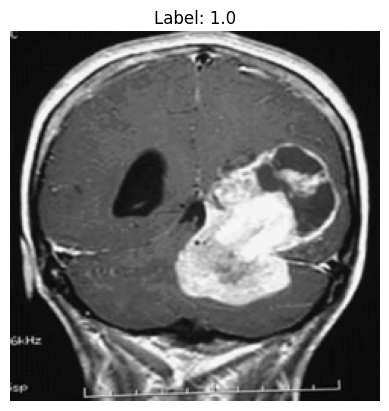

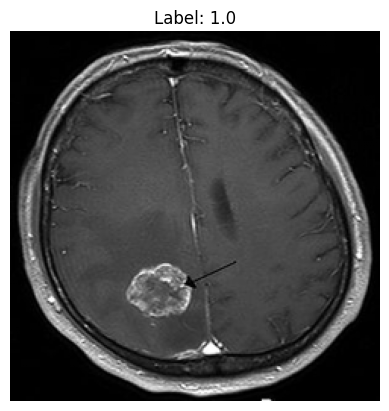

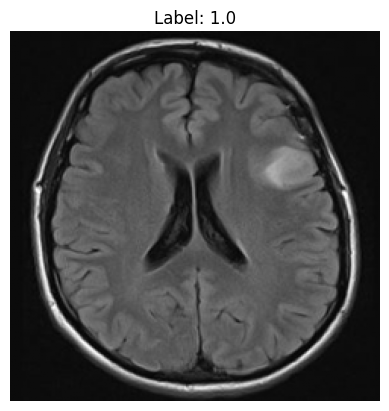

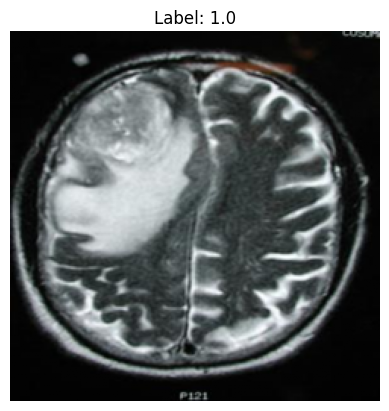

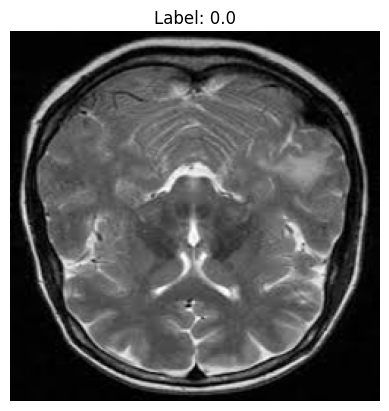

In [65]:
for image, label in train.take(5):
  plt.figure()
  plt.imshow(image.numpy())
  plt.title('Label: {}'.format(label.numpy()))
  plt.axis('off')
  plt.show()

In [66]:
validation_size = int(0.1 * 202)
train = train.skip(validation_size)
val = train.take(validation_size)

In [67]:
BATCH_SIZE = 32
train = train.batch(BATCH_SIZE)
test = train.batch(BATCH_SIZE)
val = val.batch(BATCH_SIZE)

In [84]:
from tensorflow.keras.layers import Resizing
model = Sequential()

model.add(Resizing(224, 224, input_shape=(244, 244, 3)))
model.add(Conv2D(32, (3,3), activation = 'relu', padding='valid'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

In [85]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 394272)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 256)                 │     100,933,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 100,935,041 (385.04 MB)

 Trainable params: 100,935,041 (385.04 MB)

 Non-trainable params: 0 (0.00 B)

In [86]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [87]:
history = model.fit(train, validation_data = val, epochs = 20, verbose = 1)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.6429 - loss: 16.7146 - val_accuracy: 0.8500 - val_loss: 0.8619
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.7443 - loss: 3.8502 - val_accuracy: 0.9500 - val_loss: 1.1969
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.7880 - loss: 1.5763 - val_accuracy: 0.7500 - val_loss: 0.7282
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.6867 - loss: 1.5547 - val_accuracy: 0.9500 - val_loss: 0.0903
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.8335 - loss: 0.4492 - val_accuracy: 0.9500 - val_loss: 0.0749
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.8665 - loss: 0.3043 - val_accuracy: 1.0000 - val_loss: 0.0521
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.9225 - loss: 0.2188 - val_accuracy: 1.0000 - val_loss: 0.0722
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.9322 - loss: 0.1966 - val_accuracy: 1.0000 - val_loss: 0.0394
Epoch 9

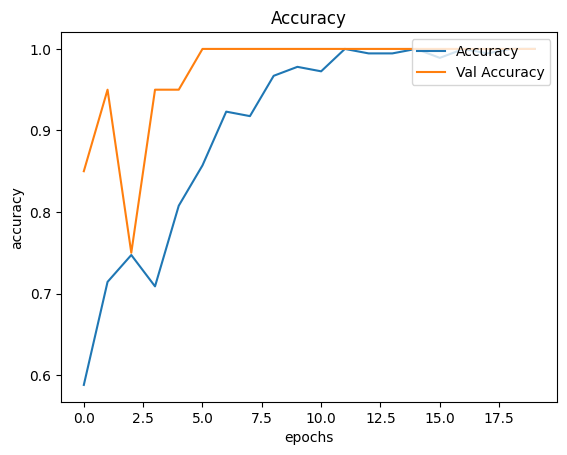

In [88]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Accuracy', 'Val Accuracy'], loc = 'upper right')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

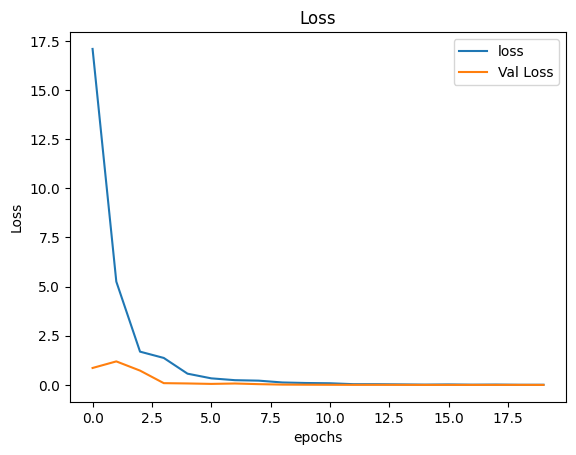

In [89]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'Val Loss'], loc = 'upper right')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.show()

In [179]:
from re import I
def load_upload_image(image_bytes):
  img = Image.open(io.BytesIO(image_bytes))
  img = img.convert("RGB")
  img = img.resize((244, 244))
  img_data = np.array(img)
  img_data = img_data / 255.0
  return img_data

def predict_image(image_bytes):
  img_data = load_upload_image(image_bytes)
  img_data = np.expand_dims(img_data, axis=0)
  prediction = model.predict(img_data)
  if prediction[0][0] > 0.5:
    return print("Positive Brain Tumour", prediction[0][0])
  else:
    return print("Negative Brain Tumour", prediction[0][0])

In [ ]:
# model = load_model("Brain-Tumour-Model.h5")